In [1]:
import  os
import  numpy as np
import  numpy.random  as rd
import scipy as sp
from scipy import stats as st
from collections import Counter

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import matplotlib.animation as ani
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]
%matplotlib inline

## 混合ガウス分布に従うデータの生成

check:  0 [ 0.2  0.5  1. ] [[ 0.1    0.085  0.085]
 [ 0.085  0.1    0.085]
 [ 0.085  0.085  0.1  ]] 6.075e-05
check:  1 [ 1.2  0.5  1. ] [[ 0.1   -0.085  0.085]
 [ 0.085  0.1   -0.085]
 [ 0.085 -0.085  0.1  ]] 0.0002775
check:  2 [ 2.   0.5  1. ] [[ 0.1    0.085  0.085]
 [ 0.085  0.1    0.085]
 [ 0.085  0.085  0.1  ]] 6.075e-05


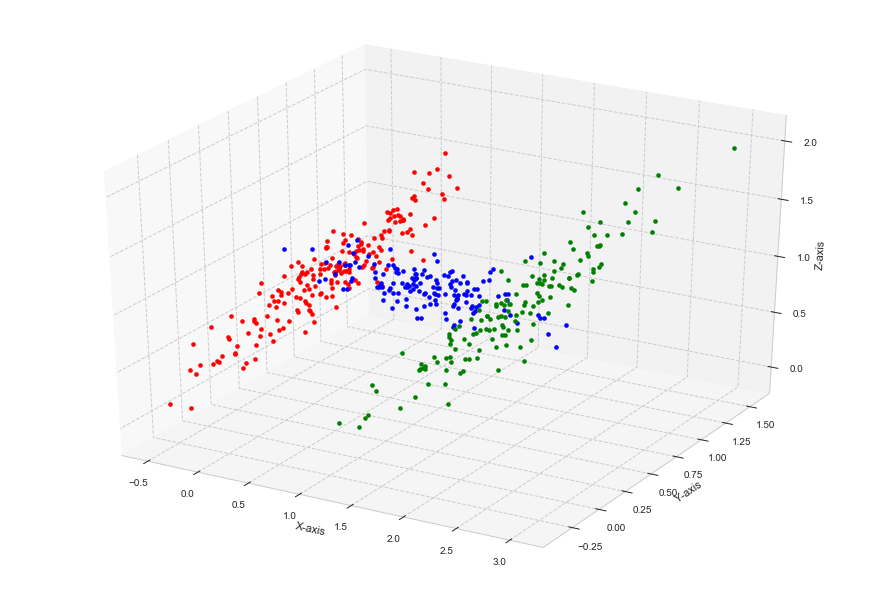

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [2]:
seed = 77
D = 2
n = [200, 150, 150]
N = np.sum(n)

mu_true = np.asanyarray(
     [[0.2, 0.5, 1.0],
      [1.2, 0.5, 1.0],
      [2.0, 0.5, 1.0]])

D = mu_true.shape[1]

sigma_true = np.asanyarray(
        [ [[0.1,  0.085, 0.085],[ 0.085, 0.1, 0.085], [0.085, 0.085, 0.1]],
          [[0.1, -0.085, 0.085],[0.085, 0.1, -0.085], [0.085, -0.085, 0.1]],
          [[0.1,  0.085, 0.085],[ 0.085, 0.1, 0.085], [0.085, 0.085, 0.1]]
        ])
c = ['r', 'g', 'b']

rd.seed(seed)
org_data = None #np.empty((np.sum(n), 3))
for i in range(3):
    print("check: ", i, mu_true[i], sigma_true[i], np.linalg.det(sigma_true[i]))
    #org_data.append(st.multivariate_normal.rvs(mean=mu[i], cov=sigma[i], size=n[i]))
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
    else:
        org_data = np.r_[org_data, np.c_[st.multivariate_normal.rvs(mean=mu_true[i], 
                                                                    cov=sigma_true[i], 
                                                                    size=n[i]), np.ones(n[i])*i]]


# グラフ作成
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig)

# 軸ラベルの設定
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

# 表示範囲の設定
ax.set_xlim(np.min(org_data[:, 0])-0.1, np.max(org_data[:, 0])+0.1)
ax.set_ylim(np.min(org_data[:, 1])-0.1, np.max(org_data[:, 1])+0.1)
ax.set_zlim(np.min(org_data[:, 2])-0.1, np.max(org_data[:, 2])+0.1)

# 抽出条件設定
d1 = org_data[org_data[:, 3] == 0]
d2 = org_data[org_data[:, 3] == 1]
d3 = org_data[org_data[:, 3] == 2]


# グラフ描画
ax.plot(d1[:,0], d1[:,1], d1[:,2], "o", color="red", ms=4, mew=0.5)
ax.plot(d2[:,0], d2[:,1], d2[:,2], "o", color="blue", ms=4, mew=0.5)
ax.plot(d3[:,0], d3[:,1], d3[:,2], "o", color="green", ms=4, mew=0.5)
#ax.plot(org_data[:, 0], org_data[:, 1], org_data[:, 2], ".")
plt.show()
# drop true cluster label
data = org_data[:,0:3].copy()
plt.figure(figsize=(12, 5))
#for i in range(3):
#    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.5)

### EMアルゴリズムの動作確認

### 真の混合ガウス分布

In [3]:
def visualize(data, mu, sigma, pi, gamma, mu_prev, K):
    # visualize
    plt.figure(figsize=(12,8))
    for i in range(N):
        plt.scatter(data[i,0], data[i,1], s=30, c=gamma[i], alpha=0.5, marker="+")

    for i in range(K):
        ax = plt.axes()
        ax.arrow(mu_prev[i, 0], mu_prev[i, 1], mu[i, 0]-mu_prev[i, 0], mu[i, 1]-mu_prev[i, 1],
                  lw=0.8, head_width=0.02, head_length=0.02, fc='k', ec='k')
        plt.scatter([mu_prev[i, 0]], [mu_prev[i, 1]], c=c[i], marker='o', alpha=0.8)
        plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
        plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')

    print_gmm_contour(data, mu, sigma, pi, K)

In [5]:
import os
home_dir = os.getcwd()
os.chdir("../src")
from em import EM
os.chdir(home_dir)

K = 3
prm = 0.1
em = EM(data, K)
em.EM_Algorithm(data, prm)

# 可視化
print("step:", em.t)
#visualize(data, em.mu, em.sigma, em.pi, em.gamma, em.mu_prev, em.K)

step: 27


In [ ]:
em.